In [ ]:
!pip install datasets evaluate

In [ ]:
import random
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
import huggingface_hub
huggingface_hub.login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import set_seed
SEED = 0
set_seed(SEED)

# Deterministic behavior (may slow training)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)


seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")
    model.to(device)

In [ ]:
def load_loso_from_serialized(csv_path, holdout_genome_ids, lowercase=True):
    """
    Load dataset and split by Leave-One-Species-Out (LOSO) using exact genome IDs.

    Args:
        csv_path (str): Path to the dataset.
        holdout_genome_ids (list[str]): Genome IDs to leave out (e.g., ["83333", "224308"])
        lowercase (bool): Whether to lowercase the input text

    Returns:
        DatasetDict with 'train' and 'test'
    """
    # Load dataset
    dataset = load_dataset("csv", data_files=csv_path)["train"]

    # Normalize genome_id to string (very important)
    dataset = dataset.map(lambda x: {"genome_id": str(x["genome_id"])})

    # Optionally lowercase the input text
    if lowercase:
        dataset = dataset.map(lambda x: {"text": x["text"].lower()})

    # Filter by exact match
    test_dataset = dataset.filter(lambda x: str(x["genome_id"]) in holdout_genome_ids)
    train_full_dataset = dataset.filter(lambda x: str(x["genome_id"]) not in holdout_genome_ids)

    # Split the training set further into train and validation (90-10 split)
    train_validation_split = train_full_dataset.train_test_split(test_size=0.1, seed=0)
    train_dataset = train_validation_split["train"]
    validation_dataset = train_validation_split["test"]

    print(f"✅ LOSO split complete.")
    print(f"Training size: {len(train_dataset)}")
    print(f"Validation size: {len(validation_dataset)}")
    print(f"Testing size: {len(test_dataset)} (Holdout: {holdout_genome_ids})")

    return DatasetDict({
        "train": train_dataset,
        "validation": validation_dataset,
        "test": test_dataset
    })

In [ ]:
def load_split_from_serialized(path, valid_size = 0.1, test_size = 0.1, seed=0):
    """
    Loads a serialized CSV file and splits it into training, validation, and test sets.

    Args:
        path (str): Path to the serialized CSV file (must include 'text', 'label', etc.).
        valid_size (float): Proportion of the dataset to include in the validation split.
        test_size (float): Proportion of the dataset to include in the test split.
        seed (int): Random seed for reproducibility.

    Returns:
        DatasetDict with 'train', 'validation', and 'test' datasets.
    """
    df = pd.read_csv(path)

    if "text" not in df.columns or "label" not in df.columns:
        raise ValueError("CSV file must contain 'text' and 'label' columns.")

    # First split: separate test set from the rest
    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df["label"], random_state=seed, shuffle=True)

    # Calculate the proportion of validation set relative to the combined train+val set
    # For example, if valid_size=0.1 and train_size=0.8, then valid_ratio_in_train_val = 0.1 / (0.8 + 0.1) = 0.1 / 0.9 = 1/9
    valid_ratio_in_train_val = valid_size / (1.0 - test_size)

    # Second split: separate validation set from the training set
    train_df, valid_df = train_test_split(train_val_df, test_size=valid_ratio_in_train_val, stratify=train_val_df["label"], random_state=seed, shuffle=True)

    return DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(valid_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True))
    })

In [ ]:
def load_species_split_from_serialized(path, species_id, test_size=0.2, seed=0):
    """
    Loads and splits data for a single species from a serialized CSV file.

    Args:
        path (str): Path to the serialized CSV file.
        species_id (str or int): Genome ID to filter by (e.g., "511145" for E. coli).
        test_size (float): Fraction of data to reserve for testing.
        seed (int): Random seed for reproducibility.

    Returns:
        DatasetDict with 'train' and 'test' datasets for that species.
    """
    df = pd.read_csv(path)

    if "genome_id" not in df.columns or "text" not in df.columns or "label" not in df.columns:
        raise ValueError("CSV must contain 'genome_id', 'text', and 'label' columns.")

    # Filter to the specified genome/species
    df_species = df[df["genome_id"].astype(str) == str(species_id)]

    if df_species.empty:
        raise ValueError(f"No examples found for genome ID: {species_id}")

    train_df, test_df = train_test_split(
        df_species,
        test_size=test_size,
        stratify=df_species["label"],
        random_state=seed
    )

    return DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True))
    })

In [ ]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   #predictions = np.argmax(predictions[0], axis=1)
   predictions = np.argmax(predictions, axis=-1) # for roberta?

   return accuracy.compute(predictions=predictions, references=labels)

# Training The Model via Leave One-Species-Out(LOSO)

## Choosing the DataSet

In [ ]:
data_path_ecoli = "/content/ecoli_function_family_conservation.csv"
data_path_bsubtilis = "/content/bsubtilis_function_family_conservation.csv"

## Choosing the LLM

In [ ]:
model_id = "roberta-base"

## Leave `E. coli` with `id:511145` out  

In [ ]:
imdb_511145 = load_loso_from_serialized(data_path_ecoli, '511145')

✅ LOSO split complete.
Training size: 5142
Validation size: 572
Testing size: 822 (Holdout: 511145)


In [ ]:
print(imdb_511145)

DatasetDict({
    train: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 5142
    })
    validation: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 572
    })
    test: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 822
    })
})


In [ ]:
tokenizer_511145 = AutoTokenizer.from_pretrained(model_id,device_map = 'auto')
model_511145 = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
def preprocess_function(examples):
   return tokenizer_511145(examples["text"])

In [ ]:
tokenized_imdb_511145 = imdb_511145.map(preprocess_function, batched=True)

In [ ]:
training_args = TrainingArguments(
   output_dir="operons_family_function_conservation_511145",
   learning_rate=3e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=10,
   weight_decay=0.01, # 0001
   lr_scheduler_type= "linear", # polynomial
   seed=0,
   data_seed=0,

   load_best_model_at_end=True,
   metric_for_best_model = "accuracy",
   eval_strategy='epoch',
   save_strategy='epoch'
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_511145, max_length= 2048)

In [ ]:
trainer = Trainer(
   model = model_511145,
   args=training_args,
   train_dataset=tokenized_imdb_511145["train"],
   eval_dataset=tokenized_imdb_511145["validation"],
   data_collator=data_collator,
   compute_metrics=compute_metrics

)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.458936,0.805944
2,No log,0.409160,0.830420
3,No log,0.381733,0.837413
4,0.441654,0.380349,0.828671
5,0.441654,0.409893,0.821678
6,0.441654,0.388519,0.844406
7,0.332916,0.468497,0.804196
8,0.332916,0.450164,0.819930
9,0.332916,0.562074,0.807692
10,0.244858,0.546328,0.819930


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=1610, training_loss=0.3304196339956722, metrics={'train_runtime': 180.7736, 'train_samples_per_second': 284.444, 'train_steps_per_second': 8.906, 'total_flos': 4593767943284280.0, 'train_loss': 0.3304196339956722, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'eval_loss': 0.3889041543006897,
 'eval_accuracy': 0.8444055944055944,
 'eval_runtime': 0.597,
 'eval_samples_per_second': 958.104,
 'eval_steps_per_second': 30.15,
 'epoch': 10.0}

In [ ]:
trainer.push_to_hub()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._511145/model.safetensors:   0%|          |  833kB /  499MB            

  ..._511145/training_args.bin:   5%|4         |   238B / 5.20kB            

CommitInfo(commit_url='https://huggingface.co/bif02/operons_function_511145/commit/124264b79c85345bd0b96b1c65e8f6ff619f66d1', commit_message='End of training', commit_description='', oid='124264b79c85345bd0b96b1c65e8f6ff619f66d1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bif02/operons_function_511145', endpoint='https://huggingface.co', repo_type='model', repo_id='bif02/operons_function_511145'), pr_revision=None, pr_num=None)

## Testing on `E. coli` with `id:511145`

In [ ]:
# Reload accuracy metric to ensure it's not a float from previous runs
accuracy = evaluate.load("accuracy")

ppredictions_511145 = trainer.predict(test_dataset=tokenized_imdb_511145["test"])
llabels_511145 = ppredictions_511145.label_ids
# Unpack logits from predictions
llogits_511145 = ppredictions_511145.predictions[0] if isinstance(ppredictions_511145.predictions, tuple) else ppredictions_511145.predictions
ppreds_511145 = np.argmax(llogits_511145, axis=-1)

# Sensitivity
sensitivity_511145 = recall_score(llabels_511145, ppreds_511145)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_511145, ppreds_511145).ravel()
specificity_511145 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_511145, recall_511145, thresholds_511145 = precision_recall_curve(llabels_511145, ppreds_511145)

# 2. Calculate the area under those points
pr_auc_511145 = auc(recall_511145, precision_511145)
calculated_accuracy_511145 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_511145 = (2*sensitivity_511145*precision_f)/(sensitivity_511145+precision_f)
print("Sensitivity:", sensitivity_511145)
print("Specificity:", specificity_511145)
print("accuracy:", calculated_accuracy_511145) # Print the renamed variable
print("f1-score:", f1_score_511145)
print("PR_AUC:",pr_auc_511145 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.8753462603878116
Specificity: 0.8937093275488069
accuracy: 0.8856447688564477
f1-score: 0.8705234159779613
PR_AUC: 0.8979221052963956


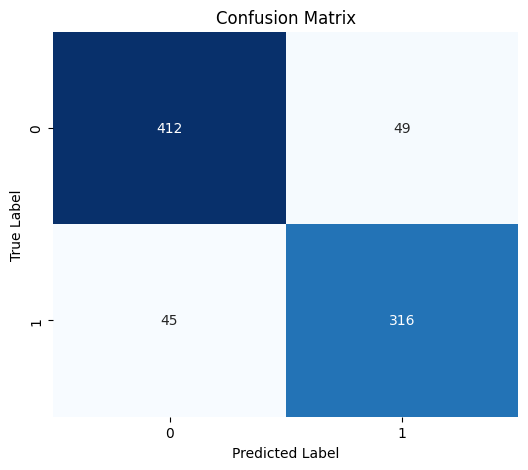

In [ ]:


# Plot Confusion Matrix
cm_511145 = confusion_matrix(llabels_511145, ppreds_511145)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_511145, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Leave `B. subtilis` with `id:224308` out  

In [ ]:
imdb_224308 = load_loso_from_serialized(data_path_bsubtilis, '224308')

✅ LOSO split complete.
Training size: 6796
Validation size: 756
Testing size: 671 (Holdout: 224308)


In [ ]:
print(imdb_224308)

DatasetDict({
    train: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 6796
    })
    validation: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 756
    })
    test: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 671
    })
})


In [ ]:
tokenizer_224308 = AutoTokenizer.from_pretrained(model_id,device_map = 'auto')
model_224308 = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
def preprocess_function(examples):
   return tokenizer_224308(examples["text"])

In [ ]:
tokenized_imdb_224308 = imdb_224308.map(preprocess_function, batched=True)

In [ ]:
training_args = TrainingArguments(
   output_dir="operons_family_function_conservation_224308",
   learning_rate=3e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=10,
   weight_decay=0.01, # 0001
   lr_scheduler_type= "linear", # polynomial
   seed=0,
   data_seed=0,

   load_best_model_at_end=True,
   metric_for_best_model = "accuracy",
   eval_strategy='epoch',
   save_strategy='epoch'
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_224308, max_length= 2048)

In [ ]:
trainer = Trainer(
   model = model_224308,
   args=training_args,
   train_dataset=tokenized_imdb_511145["train"],
   eval_dataset=tokenized_imdb_511145["validation"],
   data_collator=data_collator,
   compute_metrics=compute_metrics

)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.413013,0.814685
2,No log,0.373097,0.835664
3,No log,0.389271,0.823427
4,0.409343,0.385539,0.828671
5,0.409343,0.422538,0.814685
6,0.409343,0.387529,0.811189
7,0.338561,0.429961,0.826923
8,0.338561,0.429925,0.811189
9,0.338561,0.467452,0.804196
10,0.282333,0.464898,0.805944


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=1610, training_loss=0.33669639492627257, metrics={'train_runtime': 172.4654, 'train_samples_per_second': 298.147, 'train_steps_per_second': 9.335, 'total_flos': 4593767943284280.0, 'train_loss': 0.33669639492627257, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'eval_loss': 0.37294676899909973,
 'eval_accuracy': 0.8374125874125874,
 'eval_runtime': 0.6039,
 'eval_samples_per_second': 947.214,
 'eval_steps_per_second': 29.807,
 'epoch': 10.0}

In [ ]:
trainer.push_to_hub()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._224308/model.safetensors:  20%|##        |  101MB /  499MB            

  ..._224308/training_args.bin: 100%|##########| 5.20kB / 5.20kB            

CommitInfo(commit_url='https://huggingface.co/bif02/operons_function_224308/commit/7a8fc915328a87f72fe91d0defa77b505af60687', commit_message='End of training', commit_description='', oid='7a8fc915328a87f72fe91d0defa77b505af60687', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bif02/operons_function_224308', endpoint='https://huggingface.co', repo_type='model', repo_id='bif02/operons_function_224308'), pr_revision=None, pr_num=None)

## Testing on `B. subtilis` with `id:224308`

In [ ]:
accuracy = evaluate.load("accuracy")

ppredictions_224308 = trainer.predict(test_dataset=tokenized_imdb_224308["test"])
llabels_224308 = ppredictions_224308.label_ids
# Unpack logits from predictions
llogits_224308 = ppredictions_224308.predictions[0] if isinstance(ppredictions_224308.predictions, tuple) else ppredictions_224308.predictions
ppreds_224308 = np.argmax(llogits_224308, axis=-1)

# Sensitivity
sensitivity_224308 = recall_score(llabels_224308, ppreds_224308)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_224308, ppreds_224308).ravel()
specificity_224308 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_224308, recall_224308, thresholds_224308 = precision_recall_curve(llabels_224308, ppreds_224308)

# 2. Calculate the area under those points
pr_auc_224308 = auc(recall_224308, precision_224308)
calculated_accuracy_224308 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_224308 = (2*sensitivity_224308*precision_f)/(sensitivity_224308+precision_f)
print("Sensitivity:", sensitivity_224308)
print("Specificity:", specificity_224308)
print("accuracy:", calculated_accuracy_224308) # Print the renamed variable
print("f1-score:", f1_score_224308)
print("PR_AUC:",pr_auc_224308 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.9376693766937669
Specificity: 0.8874172185430463
accuracy: 0.9150521609538003
f1-score: 0.923898531375167
PR_AUC: 0.9412364453474326


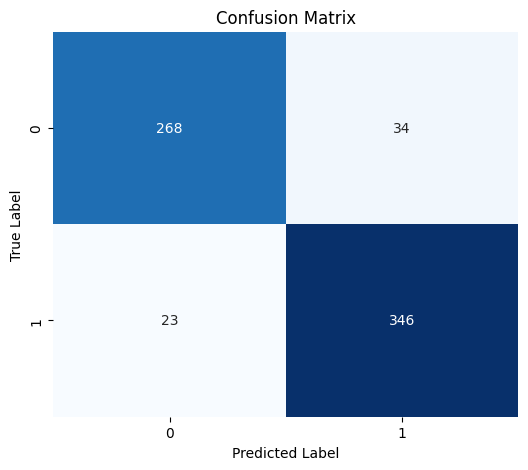

In [ ]:
# Plot Confusion Matrix
cm_224308 = confusion_matrix(llabels_224308, ppreds_224308)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_224308, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Averaging both experiments performance

In [ ]:
# Calculate Averages
avg_sensitivity = (sensitivity_511145 * 0.55 + sensitivity_224308 * 0.45)
avg_specificity = (specificity_511145 * 0.55 + specificity_224308 * 0.45)
avg_accuracy = (calculated_accuracy_511145 * 0.55 + calculated_accuracy_224308 * 0.45)
avg_f1_score = (f1_score_511145 * 0.55 + f1_score_224308 * 0.45)
avg_pr_auc = (pr_auc_511145 * 0.55 + pr_auc_224308 * 0.45)

print(f"Average Sensitivity: {avg_sensitivity}")
print(f"Average Specificity: {avg_specificity}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average F1-score: {avg_f1_score}")
print(f"Average PR_AUC: {avg_pr_auc}")

Average Sensitivity: 0.9033916627254915
Average Specificity: 0.8908778784962147
Average Accuracy: 0.8988780953002564
Average F1-score: 0.894542217906704
Average PR_AUC: 0.9174135583193623


#Testing Model Resilience on loss of features

#-Family

In [ ]:
data_path_function_conservation_ecoli = "/content/ecoli_function_conservation.csv"
data_path_function_conservation_bsubtilis = "/content/bsubtilis_function_conservation.csv"

In [ ]:
imdb_511145 = load_loso_from_serialized(data_path_function_conservation_ecoli, '511145')
imdb_224308 = load_loso_from_serialized(data_path_function_conservation_bsubtilis, '224308')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 5142
Validation size: 572
Testing size: 822 (Holdout: 511145)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 6796
Validation size: 756
Testing size: 671 (Holdout: 224308)


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_511145 = AutoTokenizer.from_pretrained("bif02/operons_function_family_conservation_511145")
model_511145 = AutoModelForSequenceClassification.from_pretrained("bif02/operons_function_family_conservation_511145")

tokenizer_224308 = AutoTokenizer.from_pretrained("bif02/operons_function_family_conservation_224308")
model_224308 = AutoModelForSequenceClassification.from_pretrained("bif02/operons_function_family_conservation_224308")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
tokenized_imdb_511145 = imdb_511145.map(preprocess_function, batched=True)
tokenized_imdb_224308 = imdb_224308.map(preprocess_function, batched=True)

Map:   0%|          | 0/5142 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_511145, max_length= 2048)

tester = Trainer(model = model_511145,data_collator=data_collator)

In [ ]:
# Reload accuracy metric to ensure it's not a float from previous runs
accuracy = evaluate.load("accuracy")

ppredictions_511145 = tester.predict(test_dataset=tokenized_imdb_511145["test"])
llabels_511145 = ppredictions_511145.label_ids
# Unpack logits from predictions
llogits_511145 = ppredictions_511145.predictions[0] if isinstance(ppredictions_511145.predictions, tuple) else ppredictions_511145.predictions
ppreds_511145 = np.argmax(llogits_511145, axis=-1)

# Sensitivity
sensitivity_511145 = recall_score(llabels_511145, ppreds_511145)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_511145, ppreds_511145).ravel()
specificity_511145 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_511145, recall_511145, thresholds_511145 = precision_recall_curve(llabels_511145, ppreds_511145)

# 2. Calculate the area under those points
pr_auc_511145 = auc(recall_511145, precision_511145)
calculated_accuracy_511145 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_511145 = (2*sensitivity_511145*precision_f)/(sensitivity_511145+precision_f)
print("Sensitivity:", sensitivity_511145)
print("Specificity:", specificity_511145)
print("accuracy:", calculated_accuracy_511145) # Print the renamed variable
print("f1-score:", f1_score_511145)
print("PR_AUC:",pr_auc_511145 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.8781163434903048
Specificity: 0.8785249457700651
accuracy: 0.878345498783455
f1-score: 0.8637602179836511
PR_AUC: 0.8907551378841059


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_224308, max_length= 2048)

tester = Trainer(model = model_224308, data_collator=data_collator)

In [ ]:
accuracy = evaluate.load("accuracy")

ppredictions_224308 = tester.predict(test_dataset=tokenized_imdb_224308["test"])
llabels_224308 = ppredictions_224308.label_ids
# Unpack logits from predictions
llogits_224308 = ppredictions_224308.predictions[0] if isinstance(ppredictions_224308.predictions, tuple) else ppredictions_224308.predictions
ppreds_224308 = np.argmax(llogits_224308, axis=-1)

# Sensitivity
sensitivity_224308 = recall_score(llabels_224308, ppreds_224308)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_224308, ppreds_224308).ravel()
specificity_224308 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_224308, recall_224308, thresholds_224308 = precision_recall_curve(llabels_224308, ppreds_224308)

# 2. Calculate the area under those points
pr_auc_224308 = auc(recall_224308, precision_224308)
calculated_accuracy_224308 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_224308 = (2*sensitivity_224308*precision_f)/(sensitivity_224308+precision_f)
print("Sensitivity:", sensitivity_224308)
print("Specificity:", specificity_224308)
print("accuracy:", calculated_accuracy_224308) # Print the renamed variable
print("f1-score:", f1_score_224308)
print("PR_AUC:",pr_auc_224308 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.9349593495934959
Specificity: 0.8874172185430463
accuracy: 0.9135618479880775
f1-score: 0.9224598930481283
PR_AUC: 0.9405085491189308


#-Function -Family

In [ ]:
data_path_conservation_ecoli = "/content/ecoli_conservation.csv"
data_path_conservation_bsubtilis = "/content/bsubtilis_conservation.csv"

In [ ]:
imdb_511145 = load_loso_from_serialized(data_path_conservation_ecoli, '511145')
imdb_224308 = load_loso_from_serialized(data_path_conservation_bsubtilis, '224308')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 5142
Validation size: 572
Testing size: 822 (Holdout: 511145)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 6796
Validation size: 756
Testing size: 671 (Holdout: 224308)


In [ ]:
tokenized_imdb_511145 = imdb_511145.map(preprocess_function, batched=True)
tokenized_imdb_224308 = imdb_224308.map(preprocess_function, batched=True)

Map:   0%|          | 0/5142 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_511145, max_length= 2048)

tester = Trainer(model = model_511145,data_collator=data_collator)

In [ ]:
# Reload accuracy metric to ensure it's not a float from previous runs
accuracy = evaluate.load("accuracy")

ppredictions_511145 = tester.predict(test_dataset=tokenized_imdb_511145["test"])
llabels_511145 = ppredictions_511145.label_ids
# Unpack logits from predictions
llogits_511145 = ppredictions_511145.predictions[0] if isinstance(ppredictions_511145.predictions, tuple) else ppredictions_511145.predictions
ppreds_511145 = np.argmax(llogits_511145, axis=-1)

# Sensitivity
sensitivity_511145 = recall_score(llabels_511145, ppreds_511145)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_511145, ppreds_511145).ravel()
specificity_511145 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_511145, recall_511145, thresholds_511145 = precision_recall_curve(llabels_511145, ppreds_511145)

# 2. Calculate the area under those points
pr_auc_511145 = auc(recall_511145, precision_511145)
calculated_accuracy_511145 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_511145 = (2*sensitivity_511145*precision_f)/(sensitivity_511145+precision_f)
print("Sensitivity:", sensitivity_511145)
print("Specificity:", specificity_511145)
print("accuracy:", calculated_accuracy_511145) # Print the renamed variable
print("f1-score:", f1_score_511145)
print("PR_AUC:",pr_auc_511145 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.8698060941828255
Specificity: 0.8199566160520607
accuracy: 0.8418491484184915
f1-score: 0.8284960422163589
PR_AUC: 0.8589578498395174


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_224308, max_length= 2048)

tester = Trainer(model = model_224308, data_collator=data_collator)

In [ ]:
accuracy = evaluate.load("accuracy")

ppredictions_224308 = tester.predict(test_dataset=tokenized_imdb_224308["test"])
llabels_224308 = ppredictions_224308.label_ids
# Unpack logits from predictions
llogits_224308 = ppredictions_224308.predictions[0] if isinstance(ppredictions_224308.predictions, tuple) else ppredictions_224308.predictions
ppreds_224308 = np.argmax(llogits_224308, axis=-1)

# Sensitivity
sensitivity_224308 = recall_score(llabels_224308, ppreds_224308)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_224308, ppreds_224308).ravel()
specificity_224308 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_224308, recall_224308, thresholds_224308 = precision_recall_curve(llabels_224308, ppreds_224308)

# 2. Calculate the area under those points
pr_auc_224308 = auc(recall_224308, precision_224308)
calculated_accuracy_224308 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_224308 = (2*sensitivity_224308*precision_f)/(sensitivity_224308+precision_f)
print("Sensitivity:", sensitivity_224308)
print("Specificity:", specificity_224308)
print("accuracy:", calculated_accuracy_224308) # Print the renamed variable
print("f1-score:", f1_score_224308)
print("PR_AUC:",pr_auc_224308 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.94579945799458
Specificity: 0.8609271523178808
accuracy: 0.9076005961251863
f1-score: 0.9184210526315789
PR_AUC: 0.9340944187568199


#-Function -Family -Conservation

In [ ]:
data_path_vanilla_ecoli = "/content/ecoli_vanilla.csv"
data_path_vanilla_bsubtilis = "/content/bsubtilis_vanilla.csv"

In [ ]:
imdb_511145 = load_loso_from_serialized(data_path_vanilla_ecoli, '511145')
imdb_224308 = load_loso_from_serialized(data_path_vanilla_bsubtilis, '224308')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Map:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6536 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 5142
Validation size: 572
Testing size: 822 (Holdout: 511145)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Map:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8223 [00:00<?, ? examples/s]

✅ LOSO split complete.
Training size: 6796
Validation size: 756
Testing size: 671 (Holdout: 224308)


In [ ]:
tokenized_imdb_511145 = imdb_511145.map(preprocess_function, batched=True)
tokenized_imdb_224308 = imdb_224308.map(preprocess_function, batched=True)

Map:   0%|          | 0/5142 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_511145, max_length= 2048)

tester = Trainer(model = model_511145,data_collator=data_collator)

In [ ]:
# Reload accuracy metric to ensure it's not a float from previous runs
accuracy = evaluate.load("accuracy")

ppredictions_511145 = tester.predict(test_dataset=tokenized_imdb_511145["test"])
llabels_511145 = ppredictions_511145.label_ids
# Unpack logits from predictions
llogits_511145 = ppredictions_511145.predictions[0] if isinstance(ppredictions_511145.predictions, tuple) else ppredictions_511145.predictions
ppreds_511145 = np.argmax(llogits_511145, axis=-1)

# Sensitivity
sensitivity_511145 = recall_score(llabels_511145, ppreds_511145)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_511145, ppreds_511145).ravel()
specificity_511145 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_511145, recall_511145, thresholds_511145 = precision_recall_curve(llabels_511145, ppreds_511145)

# 2. Calculate the area under those points
pr_auc_511145 = auc(recall_511145, precision_511145)
calculated_accuracy_511145 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_511145 = (2*sensitivity_511145*precision_f)/(sensitivity_511145+precision_f)
print("Sensitivity:", sensitivity_511145)
print("Specificity:", specificity_511145)
print("accuracy:", calculated_accuracy_511145) # Print the renamed variable
print("f1-score:", f1_score_511145)
print("PR_AUC:",pr_auc_511145 )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.8614958448753463
Specificity: 0.8524945770065075
accuracy: 0.8564476885644768
f1-score: 0.8405405405405405
PR_AUC: 0.8714517852088278


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_224308, max_length= 2048)

tester = Trainer(model = model_224308, data_collator=data_collator)

In [ ]:
accuracy = evaluate.load("accuracy")

ppredictions_224308 = tester.predict(test_dataset=tokenized_imdb_224308["test"])
llabels_224308 = ppredictions_224308.label_ids
# Unpack logits from predictions
llogits_224308 = ppredictions_224308.predictions[0] if isinstance(ppredictions_224308.predictions, tuple) else ppredictions_224308.predictions
ppreds_224308 = np.argmax(llogits_224308, axis=-1)

# Sensitivity
sensitivity_224308 = recall_score(llabels_224308, ppreds_224308)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_224308, ppreds_224308).ravel()
specificity_224308 = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_224308, recall_224308, thresholds_224308 = precision_recall_curve(llabels_224308, ppreds_224308)

# 2. Calculate the area under those points
pr_auc_224308 = auc(recall_224308, precision_224308)
calculated_accuracy_224308 = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_224308 = (2*sensitivity_224308*precision_f)/(sensitivity_224308+precision_f)
print("Sensitivity:", sensitivity_224308)
print("Specificity:", specificity_224308)
print("accuracy:", calculated_accuracy_224308) # Print the renamed variable
print("f1-score:", f1_score_224308)
print("PR_AUC:", pr_auc_224308)

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.943089430894309
Specificity: 0.8675496688741722
accuracy: 0.9090909090909091
f1-score: 0.9194187582562747
PR_AUC: 0.9356466098346666
